In [409]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import col, udf, lag, rank, lit
from pyspark.sql.window import Window
import talib

In [410]:
global DoEval #是否進行模型評估

#DoEval = False
#next_date_range = ["20180528", "20180529", "20180530", "20180531", "20180601"] #設定預測區間
next_date_range = ["20180521", "20180522", "20180523", "20180524", "20180525"] #設定預測區間
DoEval = True
#next_date_range = ["20180514", "20180515", "20180516", "20180517", "20180518"] #設定預測區間
ignore_dates = [""]#設定排除日(如端午節)
#next_date_range = ["20180507", "20180508", "20180509", "20180510", "20180511"] #設定預測區間
predict_start_date = next_date_range[0]

if sc.master[0:5]=="local":
    Path = "file:/c:/D Drive/work/bigData/pySpark/TBrain_Round2_DataSet_20180601"
    #Path = "file:/Users/yungchuanlee/Documents/learn/AI競賽/ETF預測/TBrain_Round2_DataSet_20180511"
    #Path = "file:/home/hduser/app/bigdata/competition/etf/TBrain_Round2_DataSet_20180518"
else:
    Path = "hdfs://master:9000/user/hduser"
# Path = "file:/home/hduser/app/bigdata/competition/etf/TBrain_Round2_DataSet_20180525"

In [411]:
#define alias of columns
col_alias_etf= {"代碼":"etf_id", "日期": "etf_date", "中文簡稱": "etf_name", "開盤價(元)":"etf_open", 
            "最高價(元)":"etf_high", "最低價(元)":"etf_low", "收盤價(元)":"etf_close", "成交張數(張)":"etf_count"}
col_alias_stock= {"代碼":"stock_id", "日期": "stock_date", "中文簡稱": "stock_name", "開盤價(元)":"stock_open", 
            "最高價(元)":"stock_high", "最低價(元)":"stock_low", "收盤價(元)":"stock_close", "成交張數(張)":"stock_count"}#udf
def to_double(str_val):
    return float(str_val.replace(",",""))
to_double=udf(to_double)

In [412]:
#def function to read data (因檔案格式都相同)
def read_data(file_name, col_alias):
    str_cols = ["代碼","日期", "中文簡稱"]
    raw_data = spark.read.option("encoding", "Big5").csv(Path + "/" + file_name, header=True, sep=",")
    print("Total " + file_name + " count: " + str(raw_data.count()))
    #rename cols and correct type 
    num_cols = [col_name for col_name in raw_data.columns if col_name not in str_cols]
    final_data=raw_data.select( [col(str_col_name).alias(col_alias[str_col_name]) for str_col_name in str_cols] + 
                                  [to_double(col(num_col_name)).cast("double").alias(col_alias[num_col_name]) for num_col_name in num_cols] )
    final_data.printSchema()
    final_data.show(5)
    return final_data

In [413]:
print("starting import tetfp.csv(台灣18檔ETF股價資料)...")
tetfp_dt=read_data("tetfp.csv", col_alias_etf)

starting import tetfp.csv(台灣18檔ETF股價資料)...
Total tetfp.csv count: 19485
root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_name: string (nullable = true)
 |-- etf_open: double (nullable = true)
 |-- etf_high: double (nullable = true)
 |-- etf_low: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- etf_count: double (nullable = true)

+-------+--------+----------------+--------+--------+-------+---------+---------+
| etf_id|etf_date|        etf_name|etf_open|etf_high|etf_low|etf_close|etf_count|
+-------+--------+----------------+--------+--------+-------+---------+---------+
|0050   |20130102|元大台灣50          |    54.0|   54.65|   53.9|     54.4|  16487.0|
|0050   |20130103|元大台灣50          |    54.9|   55.05|  54.65|    54.85|  29020.0|
|0050   |20130104|元大台灣50          |   54.85|   54.85|   54.4|     54.5|   9837.0|
|0050   |20130107|元大台灣50          |   54.55|   54.55|   53.9|    54.25|   8910.0|
|0050   |20130108|元大台灣50     

In [414]:
#取出etf的distinct id
etf_ids = []
etf_idx_dic = {}
etf_idx = 0
for row in tetfp_dt.select("etf_id").distinct().orderBy("etf_id").collect():
    etf_ids.append(row["etf_id"])
    etf_idx_dic.update({row["etf_id"]: etf_idx})
    etf_idx += 1
etf_idx_dic
# etf_ids = ['0050   ']

{'0050   ': 0,
 '0051   ': 1,
 '0052   ': 2,
 '0053   ': 3,
 '0054   ': 4,
 '0055   ': 5,
 '0056   ': 6,
 '0057   ': 7,
 '0058   ': 8,
 '0059   ': 9,
 '006201 ': 10,
 '006203 ': 11,
 '006204 ': 12,
 '006208 ': 13,
 '00690  ': 14,
 '00692  ': 15,
 '00701  ': 16,
 '00713  ': 17}

In [415]:
etf_dic = {}
for etfid in etf_ids:
    export_dt = tetfp_dt.filter("etf_id='" +etfid+ "' and etf_date > '20140101' and etf_date < '" + predict_start_date + "'") \
        .orderBy("etf_id", "etf_date", ascending=True)
    export_pd = export_dt.toPandas()
    etf_dic.update({etfid.strip(): export_pd})

In [416]:
#functions of TA lib
#print(talib.get_functions())

In [417]:
etf_dic["0050"]["etf_close"].count()

1071

In [418]:
import math
def get_feature_pre(curr_list):
    #在feature前加上一個Nan後回傳, 第二個值則回傳原本的最後一個值作為下次的feature
    if type(curr_list) is pd.Series:
        rtn_list = curr_list.tolist()
    else:
        rtn_list = curr_list
    rtn_list = [None] + rtn_list
    return (rtn_list[:-1], [rtn_list[-1]])

def checkNan(num):
    if num == None:
        return True
    elif math.isnan(num):
        return True
    else:
        return False
    
def calculate_n_bias(close_price, ma):
#     (close price - MA)/MA
    if checkNan(close_price) or checkNan(ma):
        return None
    else:
        return (close_price - ma)/ma
    
def calculate_n_bias_list(close_ser, ma_list):
    #calculate n bias (20 days)
    bias_list = []
    for cprice, ma in zip(close_ser.tolist(), ma_list):
        bias_list.append(calculate_n_bias(cprice, ma))
    return bias_list

def calculate_bias_ma_list(ma3_list, ma6_list):
    #calculate bias_ma = (ma3-ma6)/ma6
    bias_list = []
    for ma3, ma6 in zip(ma3_list, ma6_list):
        bias_list.append(calculate_n_bias(ma3, ma6))
    return bias_list

def calculate_bias_3_6_list(bias3_list, bias6_list):
    #bias_3_6 = bias3 - bias6
    bias_list = []
    for bias3, bias6 in zip(bias3_list, bias6_list):
        if checkNan(bias3) or checkNan(bias6):
            bias_list.append(None)
        else:
            bias_list.append(bias3 - bias6)
    return bias_list

def calculate_dif(ema12_list, ema26_list):
    #差離值DIF = 12日EMA - 26日EMA 
    dif_list = []
    for ema12, ema26 in zip(ema12_list, ema26_list):
        if checkNan(ema12) or checkNan(ema26):
            dif_list.append(None)
        else:
            dif_list.append(ema12 - ema26)
    return dif_list

from sklearn.preprocessing import StandardScaler
import itertools
def create_feature(etf_pd, next_date, scaler_dic):
    close_ser = etf_pd["etf_close"]
    #EMA
    ema5 = talib.EMA(close_ser,timeperiod=5)
    ema10 = talib.EMA(close_ser,timeperiod=10)
    ema20 = talib.EMA(close_ser,timeperiod=20)
    ema30 = talib.EMA(close_ser,timeperiod=30)
    
    #make diff
    close_ser_prev, _ = get_feature_pre(close_ser)
    close_diff = calculate_dif(close_ser.tolist(), close_ser_prev)
    
    close_diff_2, _ = get_feature_pre(close_diff)
    close_diff_3, _ = get_feature_pre(close_diff_2)
    #BIAS
    #nBIAS -3, 6, 20 => (close price - MA)/MA   ,Paper 建議用20日MA
    ma3 = talib.MA(np.array(close_ser), timeperiod=3)
    ma6 = talib.MA(np.array(close_ser), timeperiod=6)
    ma20 = talib.MA(np.array(close_ser), timeperiod=20)
    nbias3 = calculate_n_bias_list(close_ser, ma3)
    nbias6 = calculate_n_bias_list(close_ser, ma6)
    nbias20 = calculate_n_bias_list(close_ser, ma20)
    
    #BIAS_ma = (ma3-ma6)/ma6
    bias_ma = calculate_bias_ma_list(ma3, ma6)
    
    #bias_3_6 = bias3 - bias6
    bias_3_6 = calculate_bias_3_6_list(nbias3, nbias6)
    
    #KD --> only use STOCHRSI
    k, d = talib.STOCHRSI(close_ser, timeperiod=9, fastk_period=3, fastd_period=3, fastd_matype=0)
    
    #差離值DIF = 12日EMA - 26日EMA 
    ema12 = talib.EMA(close_ser,timeperiod=12)
    ema26 = talib.EMA(close_ser,timeperiod=26)
    dif = calculate_dif(ema12, ema26)
    
    #MACD
#     macd1, macdsignal1, macdhist1 = talib.MACD(close_ser, fastperiod=12, slowperiod=26, signalperiod=9)
#     macd1, macdsignal1, macdhist1 = talib.MACDEXT(close_ser, fastperiod=12, fastmatype=0, 
#                                               slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
    macd1, macdsignal1, macdhist1 = talib.MACDFIX(close_ser, signalperiod=9)
    #RSI
    rsi = talib.RSI(close_ser, timeperiod=10)
    
    #CMO
    cmo = talib.CMO(close_ser, timeperiod=14)
    
    #ROCR - Rate of change ratio: (price/prevPrice)
    #rocr = talib.ROCR(close_ser, timeperiod=10)
    #ROC - Rate of change : ((price/prevPrice)-1)*100
    rocr = talib.ROC(close_ser, timeperiod=10)
    
    #PPO - Percentage Price Oscillator
    ppo = talib.PPO(close_ser, fastperiod=12, slowperiod=26, matype=0)
    #APO - Absolute Price Oscillator
    apo = talib.APO(close_ser, fastperiod=12, slowperiod=26, matype=0)
    
    #MOM - Momentum
    mom = talib.MOM(close_ser, timeperiod=10)
    #TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
    trix = talib.TRIX(close_ser, timeperiod=30)
    #作標準化
    etfid = etf_pd["etf_id"].tolist()[0]
    tmp_pd = pd.DataFrame({"etf_id": etfid, "etf_date": etf_pd["etf_date"], "etf_close": close_diff, 
#                            "close_diff_1": close_diff, "close_diff_2": close_diff_2, "close_diff_3": close_diff_3,
                           "ema5": ema5, "ema10": ema10, "ema20": ema20, "ema30" : ema30,
                          "nbias3": nbias3, "nbias6": nbias6, "nbias20": nbias20, "bias_ma": bias_ma,
                          "bias_3_6": bias_3_6, "k": k, "d": d, "dif": dif,
                          #"macd": macd, "macdsignal": macdsignal, "macdhist": macdhist,
                          "macd1": macd1, "macdsignal1": macdsignal1, "macdhist1": macdhist1,
                          "rsi": rsi, "cmo": cmo, "rocr": rocr, "ppo": ppo, 
                           "apo": apo, "mom": mom, "trix": trix}).dropna(how='any')
    #exclude outlier
    for col in [c for c in tmp_pd.columns.values if c not in ["etf_id", "etf_date"]]:
        tmp_pd = tmp_pd[np.abs(tmp_pd[col] - tmp_pd[col].mean()) <= 3.0*tmp_pd[col].std()] #只取3倍以內標準差資料
    
    std_dic = {}
    for col in [c for c in tmp_pd.columns.values if c not in ["etf_id", "etf_date"]]:
        scaler_key = etfid.strip() + '-' + col
        if scaler_key in scaler_dic:
            scaler = scaler_dic[scaler_key]
            merged = list(itertools.chain.from_iterable(scaler.transform(tmp_pd[[col]])))
        else:
            scaler = StandardScaler()
            merged = list(itertools.chain.from_iterable(scaler.fit_transform(tmp_pd[[col]])))
            #保留etf_close的scaler在後續使用
            scaler_dic.update({scaler_key: scaler})
        std_dic.update({col: merged})
    
    #作出目前的feature table及預測用的feature table
    ema5, next_ema5 = get_feature_pre(std_dic["ema5"])
    ema10, next_ema10 = get_feature_pre(std_dic["ema10"])
    ema20, next_ema20 = get_feature_pre(std_dic["ema20"])
    ema30, next_ema30 = get_feature_pre(std_dic["ema30"])
    
    nbias3, next_nbias3 = get_feature_pre(std_dic["nbias3"])
    nbias6, next_nbias6 = get_feature_pre(std_dic["nbias6"])
    nbias20, next_nbias20 = get_feature_pre(std_dic["nbias20"])
    
    bias_ma, next_bias_ma = get_feature_pre(std_dic["bias_ma"])
    bias_3_6, next_bias_3_6 = get_feature_pre(std_dic["bias_3_6"])
    k, next_k = get_feature_pre(std_dic['k'])
    d, next_d = get_feature_pre(std_dic['d'])
    dif, next_dif = get_feature_pre(std_dic['dif'])
    
    #macd, next_macd = get_feature_pre(std_dic['macd'])
    #macdsignal, next_macdsignal = get_feature_pre(std_dic['macdsignal'])
    #macdhist, next_macdhist = get_feature_pre(std_dic['macdhist'])
    macd1, next_macd1 = get_feature_pre(std_dic['macd1'])
    macdsignal1, next_macdsignal1 = get_feature_pre(std_dic['macdsignal1'])
    macdhist1, next_macdhist1 = get_feature_pre(std_dic['macdhist1'])
                                               
    rsi, next_rsi = get_feature_pre(std_dic['rsi'])
    cmo, next_cmo = get_feature_pre(std_dic['cmo'])
    rocr, next_rocr = get_feature_pre(std_dic['rocr'])
    ppo, next_ppo = get_feature_pre(std_dic['ppo'])
    
#     close_diff_1, next_close_diff_1 = get_feature_pre(std_dic['close_diff_1'])
#     close_diff_2, next_close_diff_2 = get_feature_pre(std_dic['close_diff_2'])
#     close_diff_3, next_close_diff_3 = get_feature_pre(std_dic['close_diff_3'])
    
    #"apo": apo, "mom": mom, "trix": trix
    apo, next_apo = get_feature_pre(std_dic['apo'])
    mom, next_mom = get_feature_pre(std_dic['mom'])
    trix, next_trix = get_feature_pre(std_dic['trix'])
#     print(len(std_dic['etf_close']), ' ', len(close_diff_1), ' ', len(close_diff_2), ' ' , len(rsi))
    
    rtn_pd = pd.DataFrame({"etf_id": etfid, "idx": etf_idx_dic[etfid], "etf_date": tmp_pd["etf_date"], "close_dif": std_dic['etf_close'], 
#                            "close_diff_1": close_diff_1, "close_diff_2": close_diff_2, "close_diff_3": close_diff_3,
                           "ema5_dif": ema5, "ema10_dif": ema10, "ema20_dif": ema20, "ema30_dif" : ema30,
                          "nbias3": nbias3, "nbias6": nbias6, "nbias20": nbias20, "bias_ma": bias_ma,
                          "bias_3_6": bias_3_6, "k": k, "d": d, "dif": dif,
                          #"macd": macd, "macdsignal": macdsignal, "macdhist": macdhist,
                           "macd1": macd1, "macdsignal1": macdsignal1, "macdhist1": macdhist1,
                          "rsi": rsi, "cmo": cmo, "rocr": rocr, "ppo": ppo, 
                           "apo": apo, "mom": mom, "trix": trix}).dropna(how='any')
    #col = 'close_dif'
    #rtn_pd = rtn_pd[np.abs(rtn_pd[col] - rtn_pd[col].mean()) <= 3.0*rtn_pd[col].std()] #只取3倍以內標準差資料
    
    next_pd = pd.DataFrame({"etf_id": etfid, "idx": etf_idx_dic[etfid], "etf_date": next_date, "close_dif": -1.0, 
#                             "close_diff_1": next_close_diff_1, "close_diff_2": next_close_diff_2, "close_diff_3": next_close_diff_3,
                           "ema5_dif": next_ema5, "ema10_dif": next_ema10, "ema20_dif": next_ema20, "ema30_dif" : next_ema30,
                          "nbias3": next_nbias3, "nbias6": next_nbias6, "nbias20": next_nbias20, "bias_ma": next_bias_ma,
                          "bias_3_6": next_bias_3_6, "k": next_k, "d": next_d, "dif": next_dif,
                          #"macd": next_macd, "macdsignal": next_macdsignal, "macdhist": next_macdhist,
                            "macd1": next_macd1, "macdsignal1": next_macdsignal1, "macdhist1": next_macdhist1,
                          "rsi": next_rsi, "cmo": next_cmo, "rocr": next_rocr, "ppo": next_ppo,
                            "apo": next_apo, "mom": next_mom, "trix": next_trix})
    
    return (rtn_pd, next_pd, scaler_dic)

In [419]:
val = etf_dic["0050"][["etf_close"]]
# print(val["etf_close"].tolist())
from sklearn.preprocessing import StandardScaler
import itertools
scaler = StandardScaler()
scaler.fit_transform(val)
#merged = list(itertools.chain.from_iterable(scaler.fit_transform(val)))
#merged
scaler.inverse_transform([-1.44880072])[0]

58.451466430154937

In [420]:
#EMA
etf_pd_dic = {}
next_pd_dic = {}
scaler_dic = {}
for etfid in etf_ids:
    etf_pd, next_pd, scalers = create_feature(etf_dic[etfid.strip()], predict_start_date, {})
    etf_pd_dic.update({etfid.strip() : etf_pd})
    next_pd_dic.update({etfid.strip() : next_pd})
    scaler_dic.update(scalers)

In [421]:
etf_pd_dic["0050"].describe()

,apo,bias_3_6,bias_ma,close_dif,cmo,d,dif,ema10_dif,ema20_dif,ema30_dif,...,macdhist1,macdsignal1,mom,nbias20,nbias3,nbias6,ppo,rocr,rsi,trix
count,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,...,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000
mean,0.000268,-0.000778,0.000779,0.000065,0.000398,0.001696,0.000386,-0.001454,-0.001465,-0.001514,...,-0.001418,0.000932,-0.001045,-0.000271,0.000854,0.000978,0.000257,-0.000881,0.000273,0.001300
std,1.001030,1.000778,1.000778,1.001061,1.000989,0.999707,1.000993,1.000066,1.000052,0.999983,...,1.000116,1.000654,1.000549,1.001029,1.000720,1.000612,1.001032,1.000698,1.001028,1.000267
min,-3.150368,-2.928361,-3.001608,-3.150922,-2.880679,-1.677004,-2.961614,-1.890517,-1.776909,-1.682817,...,-2.871245,-3.096053,-2.660757,-2.718539,-2.748407,-2.967497,-2.959053,-2.810140,-2.769452,-3.039287
25%,-0.657184,-0.658100,-0.588341,-0.623068,-0.665334,-0.618474,-0.587775,-0.789215,-0.785110,-0.735134,...,-0.722593,-0.614511,-0.709734,-0.647251,-0.607538,-0.593004,-0.619884,-0.687896,-0.704039,-0.626446
50%,0.092179,-0.001519,0.003707,0.032301,0.039800,-0.004526,0.083312,-0.187442,-0.183109,-0.183908,...,-0.053239,0.090170,0.036245,0.075125,0.011256,0.066906,0.089025,0.019489,0.066418,0.038357
75%,0.682709,0.590785,0.656018,0.594047,0.668012,0.806607,0.742655,0.689460,0.646828,0.616453,...,0.629739,0.730761,0.724841,0.665789,0.670072,0.651260,0.676737,0.699725,0.702820,0.755801
max,2.114790,2.988190,2.922035,3.121900,2.901731,1.498587,2.221135,2.125782,1.993153,1.935153,...,2.664745,2.157543,2.503715,2.376649,3.011542,3.005420,2.203581,2.661079,2.618463,1.925228


In [422]:
#etf_pd_dic["0054"].describe()

In [423]:
#etf_pd_dic["00692"].describe()

In [424]:
pd_0050=etf_pd_dic["0051"]
pd_0050[np.abs(pd_0050['bias_ma'] - pd_0050['bias_ma'].mean()) >= 3*pd_0050['bias_ma'].std()]

,apo,bias_3_6,bias_ma,close_dif,cmo,d,dif,ema10_dif,ema20_dif,ema30_dif,...,macdhist1,macdsignal1,mom,nbias20,nbias3,nbias6,ppo,rocr,rsi,trix
458,-0.173644,3.063133,-3.089243,-1.050371,-1.335193,-1.739876,-0.144519,-0.850547,-0.816561,-0.843085,...,-2.560609,0.629909,-1.335520,-2.223293,-1.637535,-2.896176,-0.171106,-1.408792,-1.630287,0.296582
571,-0.906620,2.998870,-3.019269,-0.868471,-2.311188,-1.772852,-1.413588,-1.676981,-1.572370,-1.525279,...,-1.786322,-0.949991,-1.865197,-2.367057,-1.333781,-2.668289,-0.990231,-2.097455,-2.395338,-0.078313


In [425]:
#作出訓練集
etfids_1 = ['0050   ', '0052   ', '0053   ', '0054   ', '0055   ', '0057   ', '0058   ', '006203 ', '006208 ', '00690  ', '00713  ']
etfids_2 = ['0051   ', '0056   ', '0059   ', '006201 ', '006204 ', '00692  ', '00701  ']

train_dt1 = pd.concat([etf_pd_dic[etfid.strip()] for etfid in etfids_1 + etfids_2])
print('train_dt1 count:', train_dt1.shape)
train_dt2 = pd.concat([etf_pd_dic[etfid.strip()] for etfid in etfids_2])
print('train_dt2 count:', train_dt2.shape)


train_dt1 count: (13245, 26)
train_dt2 count: (4755, 26)


In [426]:
non_feature_list = ['etf_id', 'etf_date', 'close_dif', 'idx']
ema_feature_list = ['ema5_dif','ema10_dif', 'ema20_dif', 'ema30_dif']

In [427]:
#feature_cols = ema_feature_list+[col for col in list(train_dt1.columns.values) if col not in non_feature_list+ema_feature_list]
feature_cols = [col for col in list(etf_pd_dic["0050"].columns.values) if col not in non_feature_list]
print(feature_cols)

['apo', 'bias_3_6', 'bias_ma', 'cmo', 'd', 'dif', 'ema10_dif', 'ema20_dif', 'ema30_dif', 'ema5_dif', 'k', 'macd1', 'macdhist1', 'macdsignal1', 'mom', 'nbias20', 'nbias3', 'nbias6', 'ppo', 'rocr', 'rsi', 'trix']


In [428]:
# from sklearn.feature_selection import SelectKBest, f_regression
# from numpy import vstack, array, nan
# selector_dic = {}
# for eid in etf_ids:
#     etf_pd=etf_pd_dic[eid.strip()]
#     selector = SelectKBest(f_regression, k=10)
#     selector = selector.fit(etf_pd[feature_cols], etf_pd['close_dif'])
#     selector_dic.update({eid.strip(): selector})

# selector1 = SelectKBest(f_regression, k=10)
# selector1 = selector1.fit(train_dt1[feature_cols], train_dt1['close_dif'])
# selector2 = SelectKBest(f_regression, k=10)
# selector2 = selector1.fit(train_dt2[feature_cols], train_dt2['close_dif'])

In [429]:
import xgboost as xgb
#$$$ parameter
rf_model1 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
       colsample_bytree=1, max_depth=72, n_jobs=4, min_child_weight=0 )
# train_x1 = train_dt1[feature_cols].values
# train_y1 = train_dt1["close_dif"].values
# rf_model1.fit(train_x1, train_y1)

# rf_model2 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
#        colsample_bytree=1, max_depth=72, n_jobs=4, min_child_weight=0 )
# train_x2 = train_dt2[feature_cols].values
# train_y2 = train_dt2["close_dif"].values
# rf_model2.fit(train_x2, train_y2)

# model_dic = {}
# for eid in etf_ids:
#     rf_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
#         colsample_bytree=1, max_depth=24, n_jobs=4, min_child_weight=0 )
#     selector = selector_dic[eid.strip()]
#     etf_pd = etf_pd_dic[eid.strip()]
#     new_features = selector.transform(etf_pd[feature_cols])
#     rf_model.fit(new_features, etf_pd["close_dif"].values)
#     model_dic.update({eid.strip(): rf_model})

# rf_model1 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
#         colsample_bytree=1, max_depth=48, n_jobs=4, min_child_weight=0 )
# rf_model1.fit(selector1.transform(train_dt1[feature_cols]), train_dt1["close_dif"].values)
# rf_model2 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
#         colsample_bytree=1, max_depth=48, n_jobs=4, min_child_weight=0 )
# rf_model2.fit(selector2.transform(train_dt2[feature_cols]), train_dt2["close_dif"].values)

In [430]:
#train_dt1.loc[(train_dt1["etf_id"] == "0050   ") & (train_dt1["etf_date"] < predict_start_date) ].iloc[-1]["close_dif"]
# next_pd_dic["0050"]["close_dif"] = -2
# pd_0050=etf_dic["0050"]
# pd_0050#.loc[~pd_0050["etf_date"].isin(next_date_range)]

In [431]:
from pyspark.sql.types import ArrayType, DoubleType, IntegerType
#計算上或下的值(udf)
def judge_up_down_pred_native(curr_price, prev_close_price):
    if checkNan(prev_close_price):
        return 0.0
    else:
        prev_price = prev_close_price
        if curr_price == prev_price or abs(curr_price - prev_price) < 0.0001:
            return 0.0
        elif curr_price > prev_price:
            return 1.0
        else:
            return 2.0
judge_up_down_pred=udf(judge_up_down_pred_native, DoubleType())

In [432]:
# scaler_dic['0050' +'-etf_close'].inverse_transform([-1.0])[0]

In [433]:
#recover to re-run
for eid in etf_ids:
    etf_dt = etf_dic[eid.strip()]
    etf_dt = etf_dt.loc[~etf_dt["etf_date"].isin(next_date_range)]
    etf_dic.update({eid.strip(): etf_dt})
predict_res_final = []
for date in next_date_range:
    train_dt1 = pd.concat([etf_pd_dic[etfid.strip()] for etfid in etfids_1 + etfids_2])
    print('train_dt1 count:', train_dt1.shape)
    #train model
    train_x1 = train_dt1[feature_cols].values
    train_y1 = train_dt1["close_dif"].values
    rf_model1.fit(train_x1, train_y1)
    for eid in etf_ids:
        #do predict
        pred_data = next_pd_dic[eid.strip()][feature_cols].values
        if eid in etfids_1 + etfids_2:
            pred_res = rf_model1.predict(data=pred_data)
        else:
            pred_res = rf_model1.predict(data=pred_data)
#         pred_data = selector_dic[eid.strip()].transform(next_pd_dic[eid.strip()][feature_cols])
#         pred_res = model_dic[eid.strip()].predict(data=pred_data)
#         if eid in etfids_1 + etfids_2:
#             pred_data = selector1.transform(next_pd_dic[eid.strip()][feature_cols])
#             pred_res = rf_model1.predict(data=pred_data)
#         else:
#             pred_data = selector2.transform(next_pd_dic[eid.strip()][feature_cols])
#             pred_res = rf_model2.predict(data=pred_data)
        #print(pred_res)
        
        etf_dt = etf_dic[eid.strip()]
        prev_dt = etf_dt.loc[(etf_dt["etf_date"] < date) ].iloc[-1]
#         print('id of prev_dt: ', eid, ', date: ' ,prev_dt["etf_date"])
        prev_close = prev_dt["etf_close"]
#        prediction = scaler_dic[eid.strip()+'-etf_close'].inverse_transform([pred_res[0]])[0]
        prediction = prev_close + scaler_dic[eid.strip()+'-etf_close'].inverse_transform([pred_res[0]])[0]
#         print(eid, 'prev_close:', prev_close, ', diff:', scaler_dic[eid.strip()+'-etf_close'].inverse_transform([pred_res[0]])[0])
        #取出所有預測結果作合併，以進行後續成績計算
        predict_res_final.append({
            'etf_id': eid, 'etf_date': date,
            'prediction': prediction, 'pred_ud': judge_up_down_pred_native(prediction, prev_close)
        })
        
        if date != next_date_range[-1]:
            #作出新的next_pd
            new_dic = {'etf_id': [eid], 'etf_date': [date], 'etf_name': [''], 
                       'etf_open': [0.0],  'etf_high': [0.0], 'etf_low': [0.0], 'etf_close': [prediction], 'etf_count': [0.0]}
            new_pd = pd.DataFrame(data=new_dic)[['etf_id','etf_date','etf_name', 'etf_open', 'etf_high', 
                                                      'etf_low', 'etf_close', 'etf_count']]
            #print(new_pd)
            etf_dt=etf_dt.append(new_pd, ignore_index=True)
            next_date = next_date_range[next_date_range.index(date)+1]
            etf_pd2, next_pd2, scalers = create_feature(etf_dt, next_date, {})
            etf_pd_dic.update({eid.strip() : etf_pd2})
            scaler_dic.update(scalers)
            etf_dic.update({eid.strip(): etf_dt})
            next_pd_dic.update({eid.strip(): next_pd2})

pd.DataFrame(predict_res_final)

train_dt1 count: (13245, 26)
train_dt1 count: (13265, 26)
train_dt1 count: (13287, 26)
train_dt1 count: (13304, 26)
train_dt1 count: (13325, 26)


,etf_date,etf_id,pred_ud,prediction
0,20180521,0050,1.0,81.203250
1,20180521,0051,2.0,33.067788
2,20180521,0052,2.0,51.219443
3,20180521,0053,1.0,35.256669
4,20180521,0054,1.0,23.818488
5,20180521,0055,2.0,17.479071
6,20180521,0056,1.0,26.229510
7,20180521,0057,2.0,50.154384
8,20180521,0058,2.0,47.208068
9,20180521,0059,2.0,42.886309


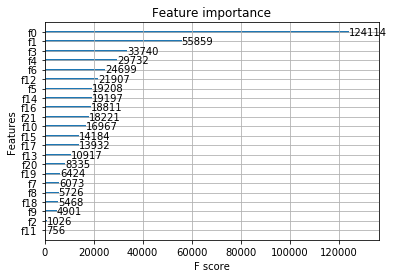

In [434]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(rf_model1)
# for eid in etf_ids:
#     plot_importance(model_dic[eid.strip()])
pyplot.show()

In [435]:
pd_0050=etf_dic["0050"]
prev_date = pd_0050.loc[~pd_0050["etf_date"].isin(next_date_range)]["etf_date"].max()
prev_date

'20180518'

In [436]:
#declare previous row windows
wsSpec_etf = Window.partitionBy('etf_id').orderBy('etf_date') #time window for normal case
#eval dt for evluate score
tetf_dt_eval = tetfp_dt.filter(tetfp_dt.etf_date.isin([prev_date] + next_date_range)) \
    .withColumn("prev_close", lag(col('etf_close')).over(wsSpec_etf)) \
    .withColumn("act_ud", judge_up_down_pred(col("etf_close"), col("prev_close")))
tetf_dt_eval = tetf_dt_eval.filter(tetf_dt_eval.etf_date.isin(next_date_range))
tetf_dt_eval.cache()
tetf_dt_eval.show()

+-------+--------+----------------+--------+--------+-------+---------+---------+----------+------+
| etf_id|etf_date|        etf_name|etf_open|etf_high|etf_low|etf_close|etf_count|prev_close|act_ud|
+-------+--------+----------------+--------+--------+-------+---------+---------+----------+------+
|00701  |20180521|   國泰臺灣低波動30    |   21.26|   21.35|   21.2|     21.3|    269.0|     21.15|   1.0|
|00701  |20180522|   國泰臺灣低波動30    |    21.3|   21.38|  21.28|    21.28|    103.0|      21.3|   2.0|
|00701  |20180523|   國泰臺灣低波動30    |   21.27|   21.28|  21.22|    21.27|     27.0|     21.28|   2.0|
|00701  |20180524|   國泰臺灣低波動30    |   21.28|   21.28|   21.2|    21.25|     37.0|     21.27|   2.0|
|00701  |20180525|   國泰臺灣低波動30    |   21.25|   21.26|  21.21|    21.21|     18.0|     21.25|   2.0|
|0051   |20180521|元大中型100         |   33.26|    33.4|  33.26|     33.4|     18.0|      33.1|   1.0|
|0051   |20180522|元大中型100         |   33.75|    33.8|  33.64|    33.65|     10.0|      33.4|   1.0|


In [437]:
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
if DoEval:
    predict_res_final_dt = spark.createDataFrame(pd.DataFrame(predict_res_final))
    eval_dt = predict_res_final_dt.join(tetf_dt_eval, ["etf_id", "etf_date"], "inner")
#     eval_dt = eval_dt.filter(trim(eval_dt.etf_id).isin(etfids_1+etfids_3))
    eval_dt.cache()
    #eval_dt.orderBy("etf_id", "etf_date", ascending=True).show(10)
    evaluator = RegressionEvaluator(
        labelCol="etf_close", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(eval_dt)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    evaluator = MulticlassClassificationEvaluator(
        labelCol="act_ud", predictionCol="pred_ud", metricName="accuracy")
    accuracy = evaluator.evaluate(eval_dt)
    print("accuracy = %g " % accuracy)
    
    #define method to evaluate by ETF way
    final_res = eval_dt.select("etf_id", "etf_date", "prediction", "pred_ud", "etf_close", "act_ud") \
        .orderBy("etf_date", "etf_id").collect()
    weights = [0.1, 0.15, 0.2, 0.25, 0.3]
    judge_score = 0.0
    for row in final_res:
        #(up equal*0.5+((act_p - abs(pred_p - act_p))/act_p)*0.5)*weight
        act_price = row["etf_close"]
        pred_price = row["prediction"]
        eidx = next_date_range.index(row["etf_date"])
        judge_score = judge_score + \
            ((0.5 if row["pred_ud"] == row["act_ud"] else 0.0) + \
             ((act_price-abs(pred_price-act_price))/act_price)*0.5)*weights[eidx]
    print("final score: ", judge_score)

#$$$
#5/21 : (RMSE) on test data = 0.445152   accuracy = 0.511111  final score:  13.483852637710193

Root Mean Squared Error (RMSE) on test data = 0.446753
accuracy = 0.466667 
final score:  13.158179174596036


In [438]:
res_dt = eval_dt.select("etf_id", "etf_date", "pred_ud", "act_ud", "prediction", "etf_close") \
    .filter("pred_ud != act_ud") \
    .orderBy("etf_id", "etf_date")
res_dt.groupBy("etf_id").count().orderBy("count").show()

+-------+-----+
| etf_id|count|
+-------+-----+
|006204 |    1|
|006208 |    1|
|0053   |    1|
|0058   |    1|
|006203 |    1|
|0050   |    2|
|0054   |    2|
|00692  |    2|
|00690  |    2|
|006201 |    2|
|00713  |    2|
|0052   |    3|
|0057   |    4|
|0056   |    4|
|00701  |    5|
|0051   |    5|
|0055   |    5|
|0059   |    5|
+-------+-----+



In [439]:
eval_pd=eval_dt.toPandas()

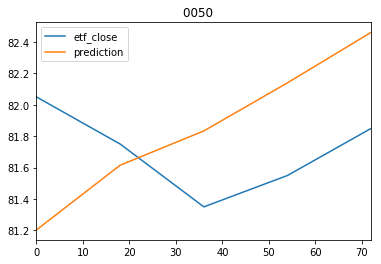

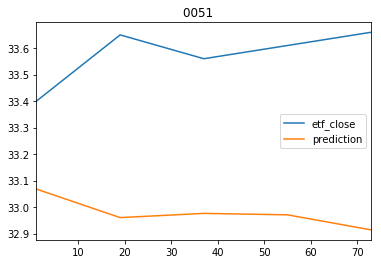

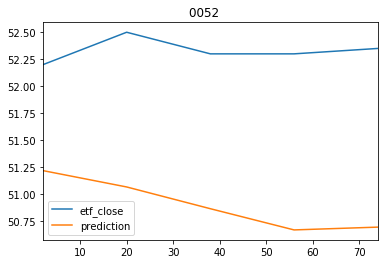

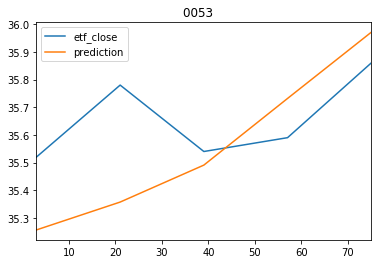

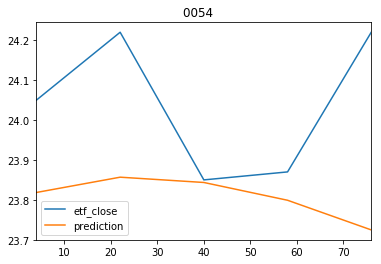

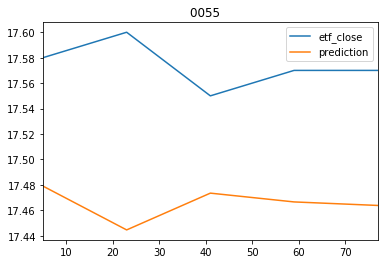

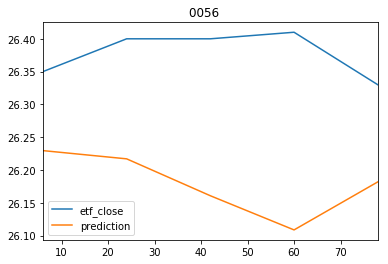

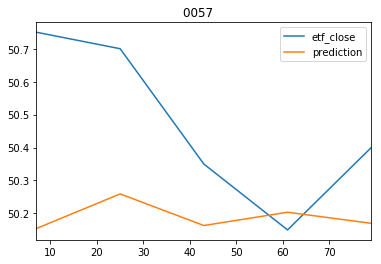

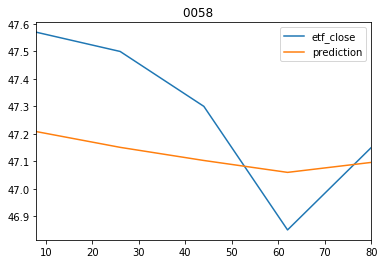

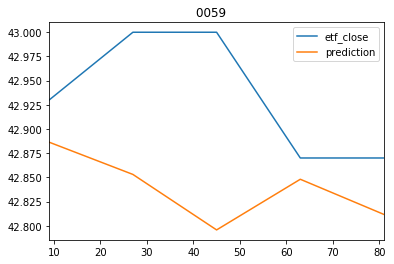

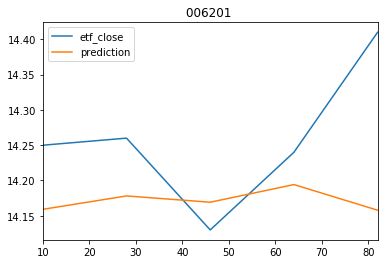

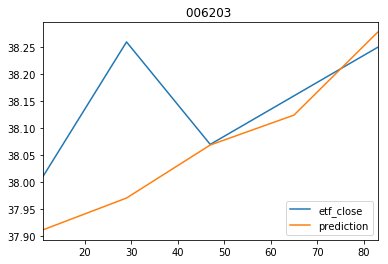

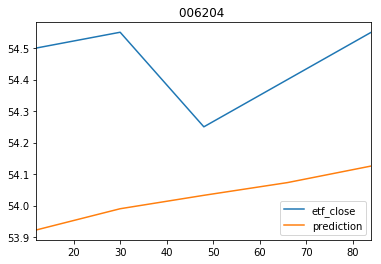

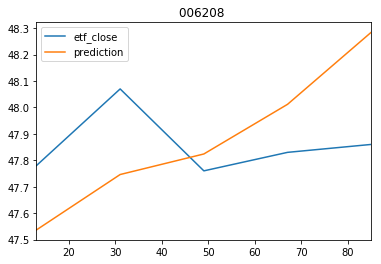

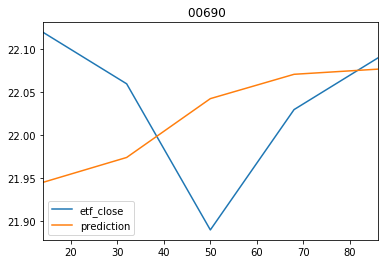

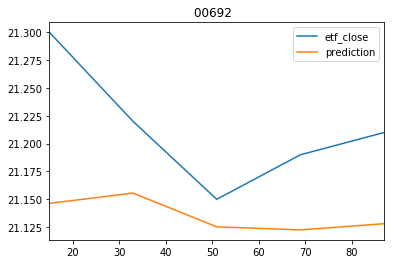

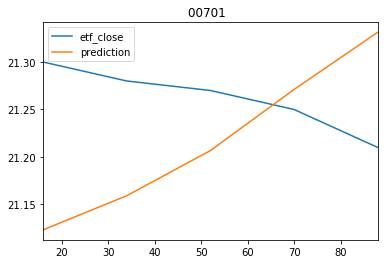

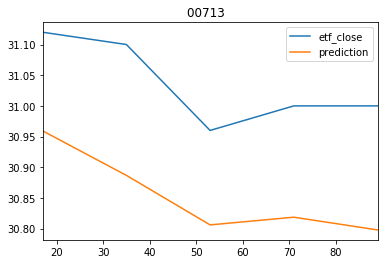

In [440]:
for eid in etf_ids:
    eval_pd[eval_pd['etf_id'].isin([eid])][['etf_close','prediction']].plot(title=eid)
pyplot.show()
